# Student's T Process Regression


Let's set some setting for this Jupyter Notebook.

In [1]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

 Now, let's import the `StudentsTProcessRegression` algorithm from the `pymc3_models` package.

In [2]:
import pymc3_models
from pymc3_models import StudentsTProcessRegression
print('Running on pymc3_models v{}'.format(pymc3_models.__version__))

Running on pymc3_models v1.1.3


## Step 1: Prepare the data
Generate synthetic data.

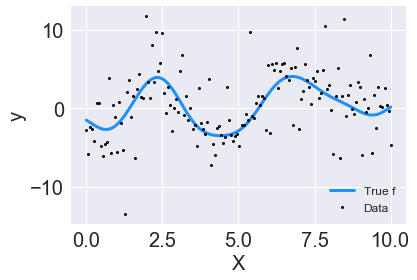

In [3]:
n = 150 # The number of data points
X = np.linspace(start = 0, stop = 10, num = n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
length_scale_true = 1.0
signal_variance_true = 3.0
cov_func = signal_variance_true**2 * pm.gp.cov.ExpQuad(1, length_scale_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
noise_variance_true = 2.0
degrees_of_freedom_true = 3.0
y = f_true + noise_variance_true * np.random.standard_t(degrees_of_freedom_true, size=n)

## Plot the data and the unobserved latent function
fig, ax = plt.subplots()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Step 2: Instantiate a model

In [5]:
model = StudentsTProcessRegression()

## Step 3: Perform Inference

In [6]:
model.fit(X_train, y_train)

Average Loss = 303.15: 100%|██████████| 200000/200000 [05:51<00:00, 569.49it/s]
Finished [100%]: Average Loss = 303.15


StudentsTProcessRegression(prior_mean=0.0)

## Step 4: Diagnose convergence

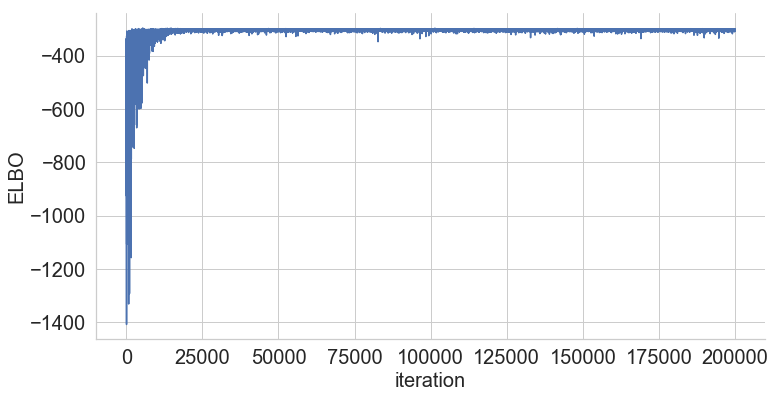

In [8]:
model.plot_elbo()

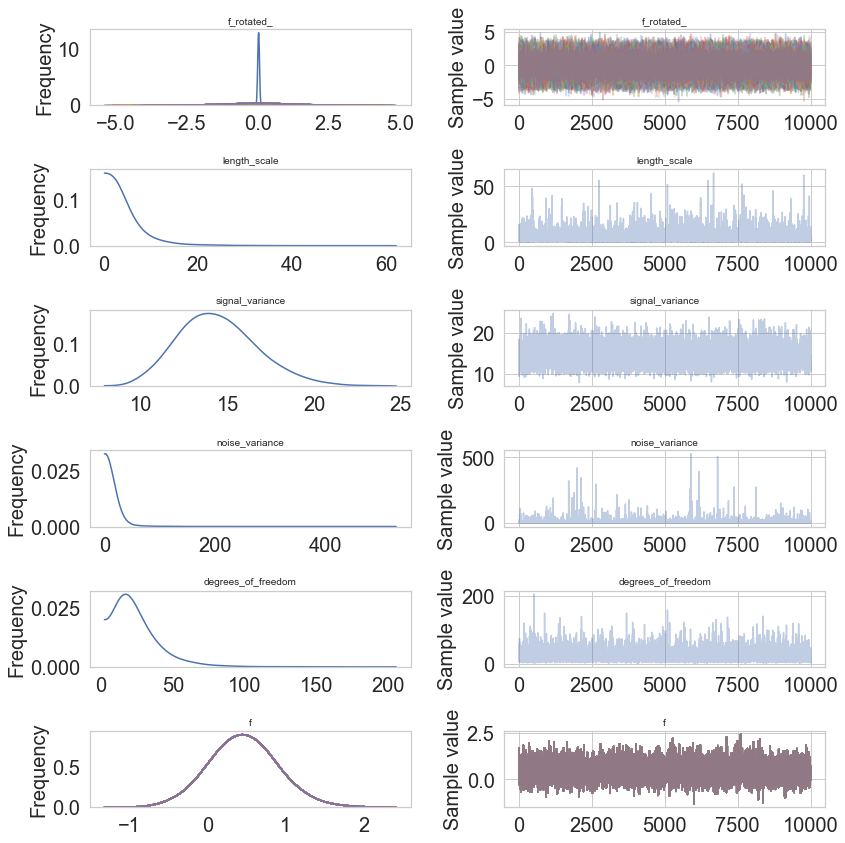

In [9]:
pm.traceplot(model.trace);

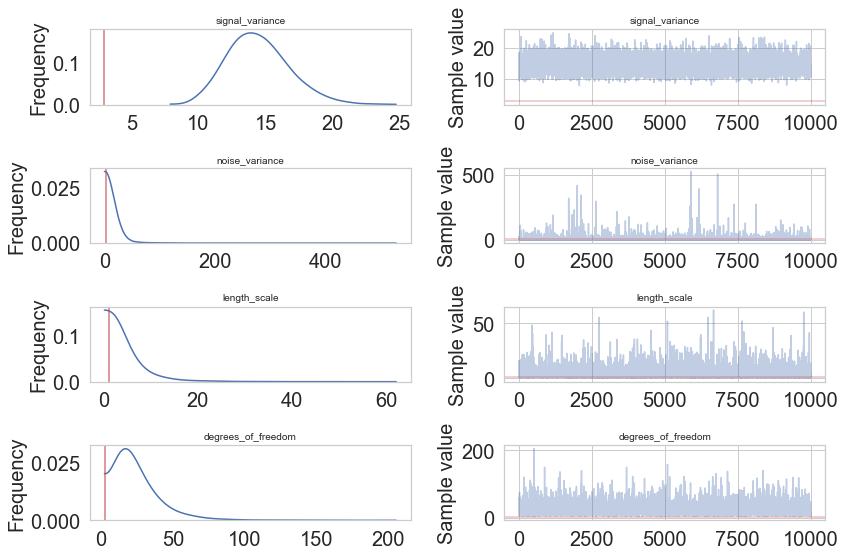

In [10]:
pm.traceplot(model.trace, lines = {"signal_variance": signal_variance_true, 
                                 "noise_variance": noise_variance_true, 
                                 "length_scale": length_scale_true, 
                                 "degrees_of_freedom": degrees_of_freedom_true}, 
             varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"]);

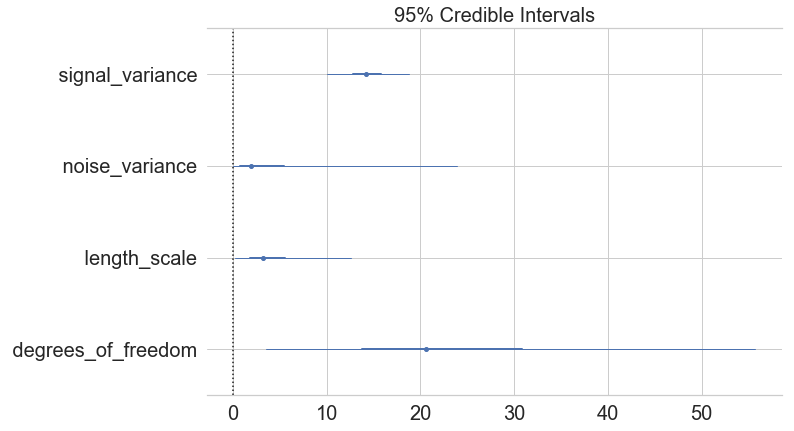

In [11]:
pm.forestplot(model.trace, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"]);

## Step 5: Criticize the model

In [12]:
pm.summary(model.trace, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
signal_variance__0,14.426387,2.285638,0.020561,10.003009,18.812945
noise_variance__0,6.182008,17.330061,0.187540,0.006105,23.940172
length_scale__0_0,4.513060,4.463835,0.042727,0.211121,12.553770
degrees_of_freedom__0,24.557327,15.961989,0.162027,3.486161,55.741969


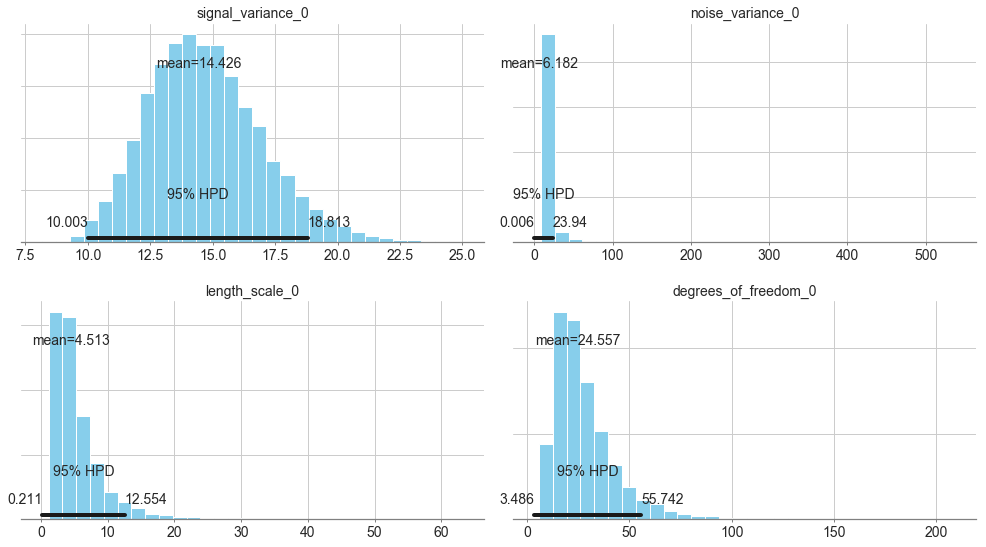

In [13]:
pm.plot_posterior(model.trace, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"], 
                 figsize = [14, 8]);

In [14]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"],
              "Predicted Mean Value": [float(model.trace["length_scale"].mean(axis=0)),
                                       float(model.trace["signal_variance"].mean(axis=0)), 
                                       float(model.trace["noise_variance"].mean(axis=0)),
                                       float(model.trace["degrees_of_freedom"].mean(axis=0))],
              "True value": [length_scale_true, signal_variance_true, 
                             noise_variance_true, degrees_of_freedom_true]})

,Parameter,Predicted Mean Value,True value
0,signal_variance,4.513060,1.0
1,noise_variance,14.426387,3.0
2,length_scale,6.182008,2.0
3,degrees_of_freedom,24.557327,3.0


## Step 6: Use the model for prediction

In [15]:
y_predict1 = model.predict(X_test)

100%|██████████| 2000/2000 [00:08<00:00, 247.33it/s]


In [16]:
y_predict1

array([0.52060618, 0.20859641, 0.32341845, 0.71517795, 0.12535947,
       0.10130519, 0.13356278, 0.48476055, 0.33239652, 0.05354277,
       0.3221012 , 0.27747592, 0.33224296, 0.16754793, 0.70514462,
       0.37293254, 0.38020924, 0.65038549, 0.34252208, 0.38382534,
       0.15502318, 0.37618247, 0.58213956, 0.63244638, 0.27682323,
       0.17309081, 0.11088147, 0.38385589, 0.05206571, 0.33370627,
       0.0590494 , 0.21805391, 0.24068462, 0.14248978, 0.16113507,
       0.6395228 , 0.13902426, 0.29770677, 0.24498306, 0.18377858,
       0.12288624, 0.35066241, 0.25833606, 0.70100999, 0.66802676])

In [24]:
model.score(X_test, y_test)

In [26]:
model.save('pickle_jar/spr')

#### Use already trained model for prediction

In [27]:
model_new = StudentsTProcessRegression()
model_new.load('pickle_jar/spr')
model_new.score(X_test, y_test)

100%|██████████| 2000/2000 [00:01<00:00, 1201.17it/s]


-0.09713232621579238

## Multiple Features

In [34]:
num_pred = 2
X = np.random.randn(1000, num_pred)
noise = 2 * np.random.randn(1000,)
Y = X.dot(np.array([4, 5])) + 3 + noise

In [35]:
y = np.squeeze(Y)

In [36]:
model_big = StudentsTProcessRegression()

In [37]:
model_big.fit(X, y, inference_args={"n" : 1000})

Average Loss = 6,129.9: 100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]
Finished [100%]: Average Loss = 6,118.9


StudentsTProcessRegression()

In [38]:
pm.summary(model_big.trace, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
signal_variance__0,7.029373,4.739398,0.049285,0.968977,16.254415
noise_variance__0,7.163999,7.395869,0.075956,0.337118,20.242566
length_scale__0_0,2.451322,1.983714,0.022889,0.256500,6.175940
length_scale__0_1,2.466894,2.009942,0.021930,0.196610,6.184087
degrees_of_freedom__0,19.622088,15.718934,0.147647,2.390572,49.401395


## MCMC

### Perform inference

In [8]:
model2 = StudentsTProcessRegression()
model2.fit(X_train, y_train, inference_type='nuts')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, degrees_of_freedom_log__, noise_variance_log__, signal_variance_log__, length_scale_log__]
100%|██████████| 2500/2500 [03:33<00:00, 11.70it/s]


StudentsTProcessRegression()

### Diagnose convergence

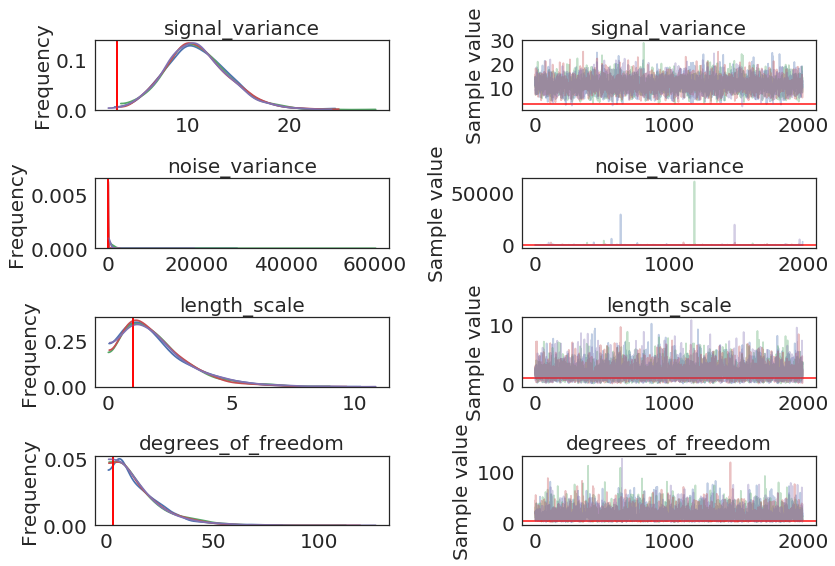

In [13]:
pm.traceplot(model2.trace, lines = {"signal_variance": signal_variance_true, 
                                 "noise_variance": noise_variance_true, 
                                 "length_scale": length_scale_true, 
                                 "degrees_of_freedom": degrees_of_freedom_true}, 
             varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"]);

In [14]:
pm.gelman_rubin(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"])

{'degrees_of_freedom': array([1.00019487]),
 'length_scale': array([[1.00008203]]),
 'noise_variance': array([0.99986753]),
 'signal_variance': array([0.99999439])}

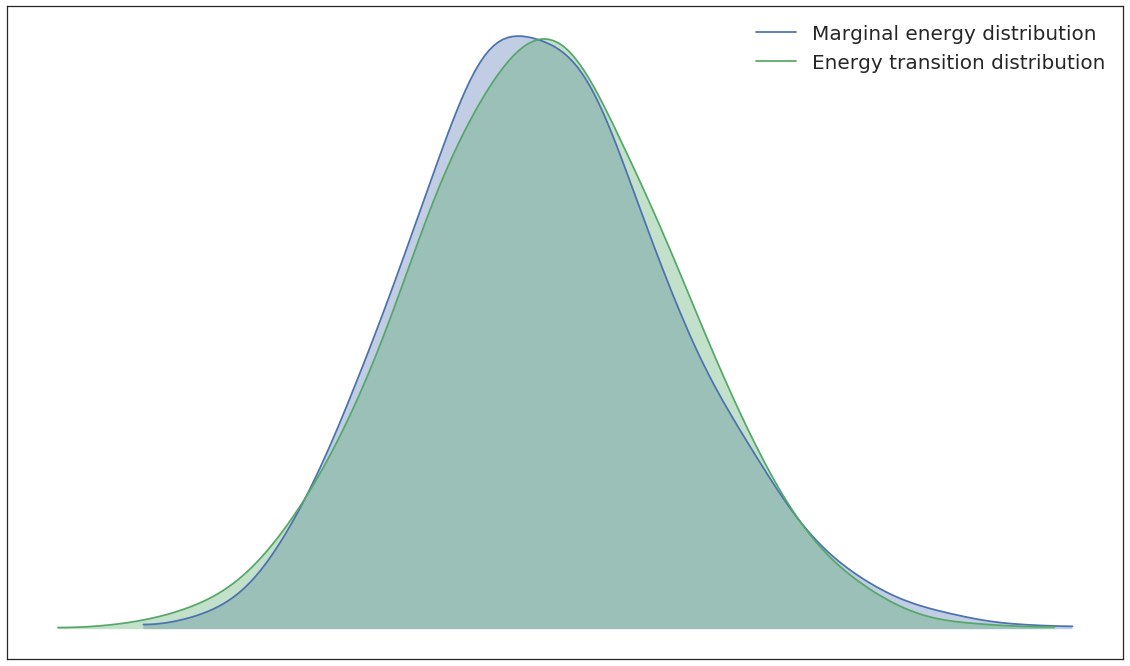

In [15]:
pm.energyplot(SPR2.trace);

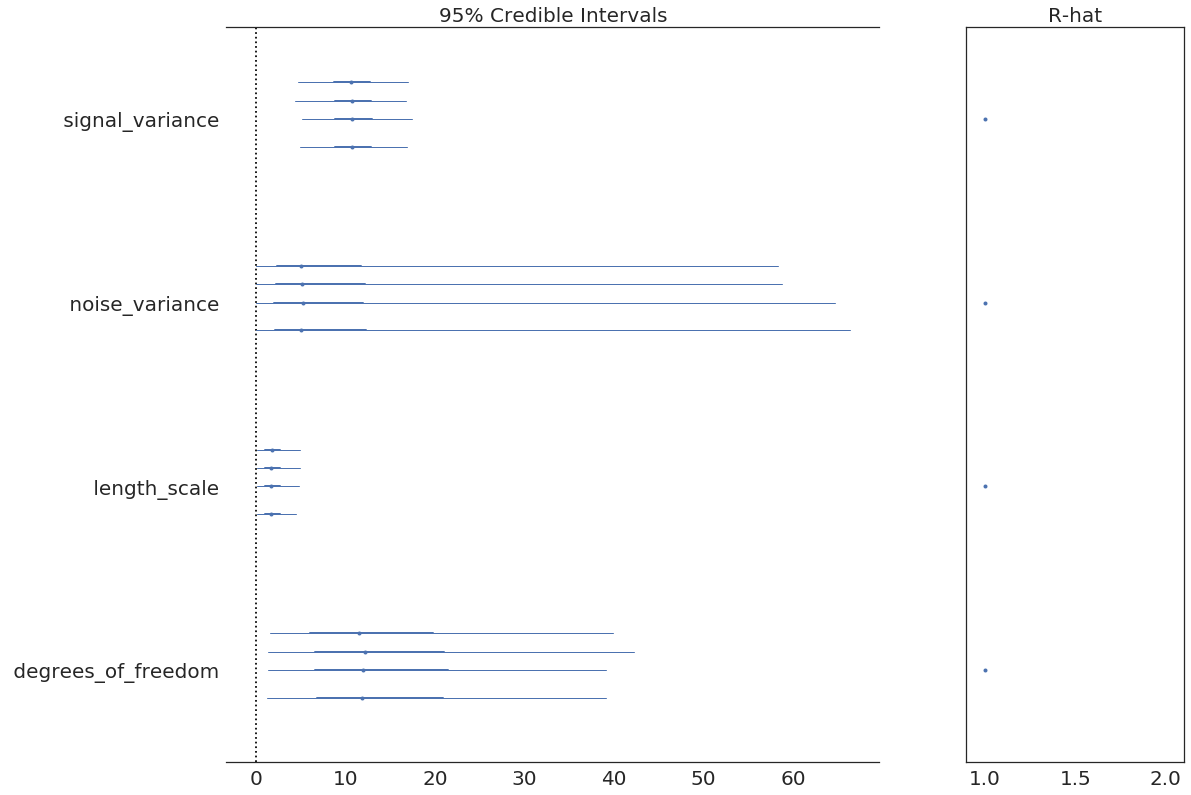

In [16]:
pm.forestplot(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"]);

### Criticize the model

In [20]:
pm.summary(model2.trace, varnames=["signal_variance", "length_scale", "noise_variance"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
signal_variance__0,10.929238,3.144499,0.043256,4.628908,16.918602,4343.913263,0.999994
length_scale__0_0,1.997809,1.397544,0.012827,0.061045,4.763012,11392.919787,1.000082
noise_variance__0,36.850186,793.367946,9.474022,0.000534,63.332892,7491.212453,0.999868


In [21]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"],
              "Predicted Mean Value": [float(model2.trace["length_scale"].mean(axis=0)),
                                       float(model2.trace["signal_variance"].mean(axis=0)), 
                                       float(model2.trace["noise_variance"].mean(axis=0)),
                                       float(model2.trace["degrees_of_freedom"].mean(axis=0))],
              "True value": [length_scale_true, signal_variance_true, 
                             noise_variance_true, degrees_of_freedom_true]})

,Parameter,Predicted Mean Value,True value
0,signal_variance,1.997809,1.0
1,noise_variance,10.929238,3.0
2,length_scale,36.850186,2.0
3,degrees_of_freedom,15.509439,3.0


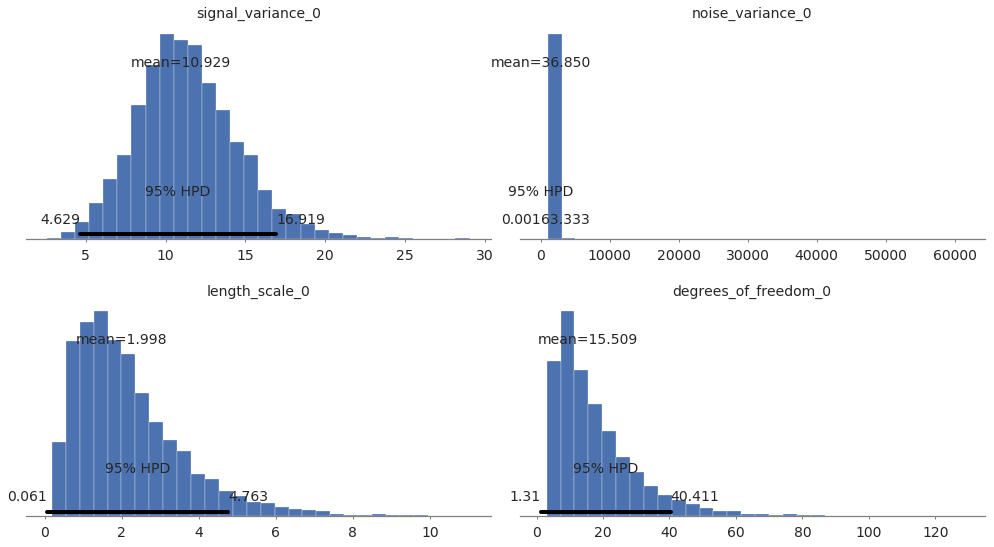

In [22]:
pm.plot_posterior(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"], 
                 figsize = [14, 8]);

### Use the model for prediction

In [28]:
y_predict2 = model2.predict(X_test)

100%|██████████| 2000/2000 [00:01<00:00, 1174.91it/s]


In [29]:
y_predict2

array([1.67834026, 1.64158368, 1.53728732, 1.56489496, 1.48686425,
       1.48626043, 1.57801849, 1.5609818 , 1.57435388, 1.76800657,
       1.56198154, 1.49355969, 1.72304612, 1.53818178, 1.68932836,
       1.6059991 , 1.62152421, 1.50726857, 1.92453348, 1.61906672,
       1.4703559 , 1.49874483, 1.63398678, 1.72795675, 1.62348916,
       1.65877512, 1.78012082, 1.65401634, 1.47100635, 1.51878226,
       1.53634253, 1.66642193, 1.5899548 , 1.62872435, 1.66256587,
       1.67191658, 1.45945213, 1.43421284, 1.52586924, 1.56299994,
       1.79883016, 1.6769178 , 1.52190602, 1.58302155, 1.44959024,
       1.66465733, 1.5804623 , 1.62288222, 1.53714604, 1.80406125])

In [30]:
model2.score(X_test, y_test)

100%|██████████| 2000/2000 [00:01<00:00, 1254.66it/s]


-0.0069721816446493

In [31]:
model2.save('pickle_jar/spr2')
model2_new = StudentsTProcessRegression()
model2_new.load('pickle_jar/spr2')
model2_new.score(X_test, y_test)

100%|██████████| 2000/2000 [00:01<00:00, 1104.45it/s]


0.0038373353227000306

## Compare models

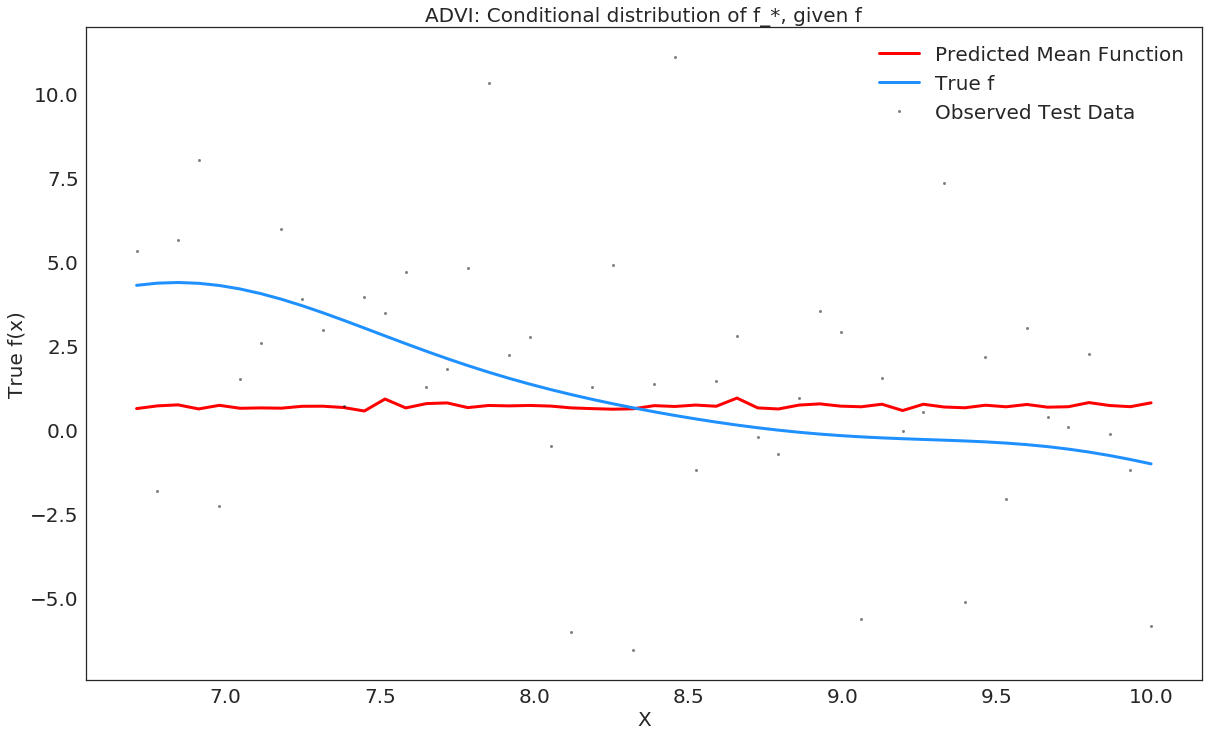

In [32]:
# plot the results
fig, ax = plt.subplots()

# plot the samples of the gp posterior
plt.plot(X_test, y_predict1, "r", lw=3, label="Predicted Mean Function")

plt.plot(X_train, f_true[100:], "dodgerblue", lw=3, label="True f");
plt.plot(X_test, y_test, 'ok', ms=3, alpha=0.5, label="Observed Test Data");
plt.xlabel("X") 
plt.ylabel("True f(x)");
plt.title("ADVI: Conditional distribution of f_*, given f");
plt.legend();

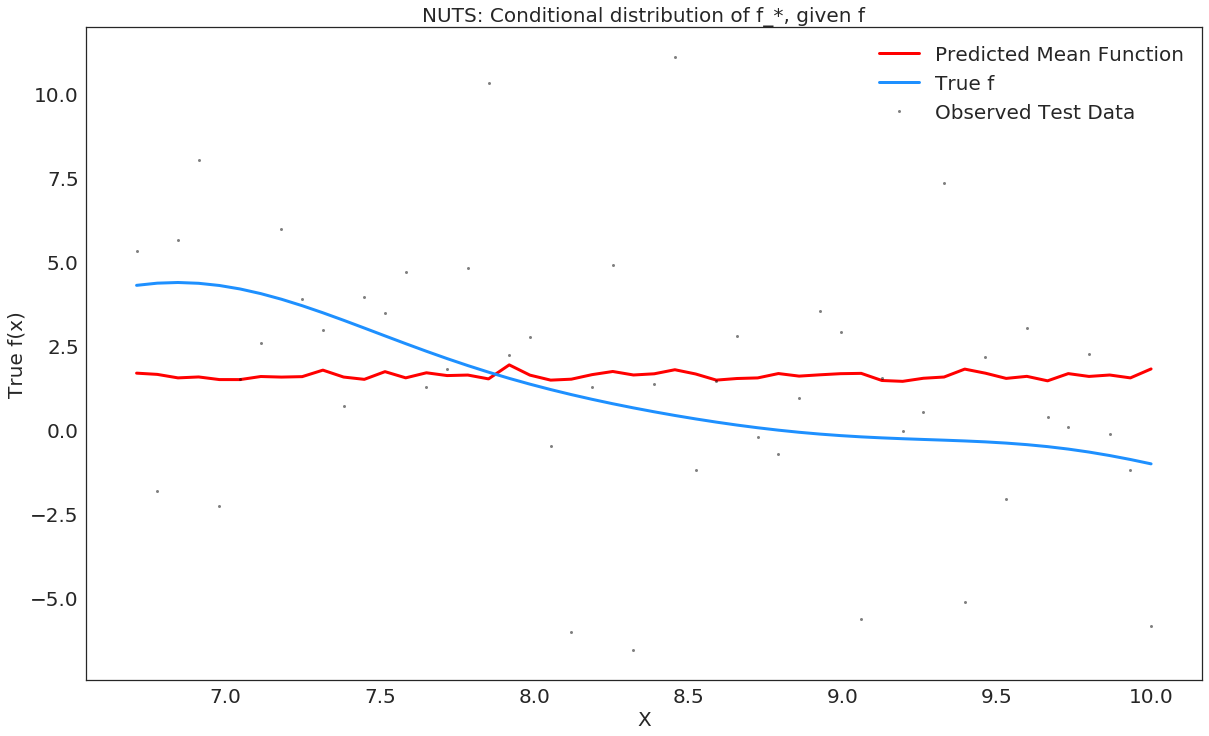

In [33]:
# plot the results
fig, ax = plt.subplots()

# plot the samples of the gp posterior
plt.plot(X_test, y_predict2, "r", lw=3, label="Predicted Mean Function")

plt.plot(X_train, f_true[100:], "dodgerblue", lw=3, label="True f");
plt.plot(X_test, y_test, 'ok', ms=3, alpha=0.5, label="Observed Test Data");
plt.xlabel("X") 
plt.ylabel("True f(x)");
plt.title("NUTS: Conditional distribution of f_*, given f");
plt.legend();